# Защита персональных данных клиентов

## Цель 

Разработайть метод преобразования данных для компании «Хоть потоп»<br>
С целью защиты персональных данных её клиентов <br>
Что бы по ним было сложно восстановить персональную информацию<br>

Доказать корректность работы метода<br>
<br>
При этом:<br>
Качество модели на преобразованных данных должно соответствовать качеству модели на исходных данных<br>

## Описание данных

Набор данных находится в файле https://code.s3.yandex.net/datasets/insurance.csv
- Признаки: пол, возраст, зарплата застрахованного, количество членов его семьи
- Целевой признак: количество страховых выплат клиенту за последние 5 лет

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from scipy import stats as st
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, r2_score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor

In [3]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

In [4]:
try:
    import phik
    from phik.report import plot_correlation_matrix
    from phik import report
except:
    !pip install phik
    import phik
    from phik.report import plot_correlation_matrix
    from phik import report

In [5]:
try:
    data = pd.read_csv('insurance.csv')

except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/insurance.csv')
  

In [6]:
def isna_count_procent(data, name):
    isna_columns = data.isna().sum() > 0
    isna_columns = pd.DataFrame([data.isna().sum()[isna_columns]/data.shape[0], data.isna().sum()[isna_columns]]).T
    isna_columns = isna_columns.rename(columns={0: 'procent', 1: 'count'})
    isna_columns['count'] = isna_columns['count'].map('{:,.2f}'.format)
    isna_columns['procent'] = isna_columns['procent'].map('{:,.2%}'.format)
    isna_columns = isna_columns.sort_values('procent', ascending=False)
    # блок показывае всё о данных
    display(data.head(5))
    print('#'*55)
    print()
    display(data.describe())
    print('#'*55)
    print()
    data.info()
    print('#'*55)
    isna = data.isna().sum().sum()
    isna_procent = isna/data.shape[0]
    print()
    print(f'Всего пропусков в {name} {isna} шт. в {len(isna_columns)} столбцах')
    print(f'В процентном отношении {isna_procent:.2%} шт. от {data.shape[0]} длинны')
    print()
    s = data.duplicated().sum()
    print(f'Количество дубликатов в данных  равно {s}')

    return isna_columns, pd.set_option('display.max_rows', None)

In [7]:
isna_count_procent(data, 'insurance.csv')

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


#######################################################



,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


#######################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB
#######################################################

Всего пропусков в insurance.csv 0 шт. в 0 столбцах
В процентном отношении 0.00% шт. от 5000 длинны

Количество дубликатов в данных  равно 153


(Empty DataFrame
 Columns: [procent, count]
 Index: [],
 None)

In [8]:
# удалим дубоикаты в данных
data = data.drop_duplicates().reset_index(drop=True)

s = data.duplicated().sum()
print(f'Количество дубликатов в данных  равно {s}')
print(f'Количество строк insurance.csv после удаления дубликатов {data.shape[0]}')

Количество дубликатов в данных  равно 0
Количество строк insurance.csv после удаления дубликатов 4847


In [9]:
# поправим названия признаков 
data.columns = data.columns.str.lower() 
data = data.rename(columns={'члены семьи': 'члены_семьи', 'страховые выплаты': 'страховые_выплаты'})
data['возраст'] = data['возраст'].astype(int)

Познакомились с данными, удалили дубликаты в строках<br>
Пропуски отсутствуют<br>
В данных 5 столбцов все в числовом формате<br>
Признак `пол` закодирован в нули и единицы, это единственный категориальный признак<br>
Привели названия признаков к нижнему регистру<br>
Признак `возраст` поменяли тип на целочисленный<br>

In [10]:
# функция гистограммы данных 
def data_hist(data, name_data):
    fig, (ax, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(25, 2))
    fig.text(0.45, 0.95, f'Гистограммы {name_data}', size='x-large', weight='bold')

    sns.histplot(data = data['пол'], edgecolor='black', bins=40, linewidth=1, ax=ax)
    sns.histplot(data = data['возраст'], edgecolor='black', bins=40, linewidth=1, ax=ax1)
    sns.histplot(data = data['зарплата'], edgecolor='black', bins=30, linewidth=1, ax=ax2)
    sns.histplot(data = data['члены_семьи'], edgecolor='black', bins=40, linewidth=1, ax=ax3)
    sns.histplot(data = data['страховые_выплаты'], edgecolor='black', bins=40, linewidth=1, ax=ax4)
    
    plt.show()

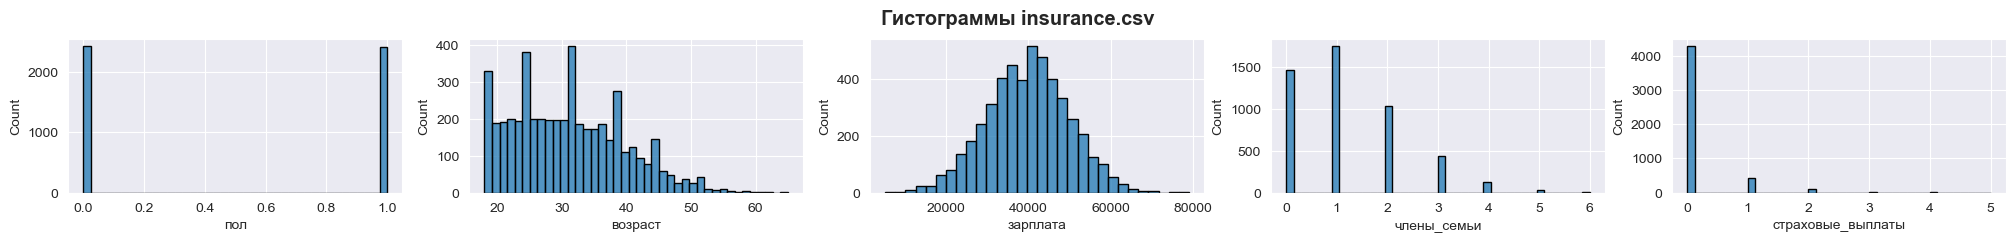

In [11]:
# построим гистограммы наших данных
data_hist(data, 'insurance.csv')

Данные распределены согласованно с логикой<br>
В признаке `возраст` присутствуют всплески <br>
У признака `зарплата` распределение нормальное<br>

In [12]:
def corr_psk(data): 
    fig, (ax, ax1, ax2, ax3 ) = plt.subplots(1, 4, figsize=(35, 4))

    sns.heatmap(data = data.corr(), annot=True, ax=ax).set_title('Корреляция Пирсона', weight='bold', size='large');
    sns.heatmap(data = data.corr(method = 'spearman'), annot=True, ax=ax1).set_title('Корреляция Спирмена', weight='bold', size='large');
    sns.heatmap(data = data.corr(method = 'kendall'), annot=True, ax=ax2).set_title('Корреляция Кенделла', weight='bold', size='large');
    sns.heatmap(data = data.phik_matrix(interval_cols=data.columns), annot=True, ax=ax3).set_title('Корреляция $\phi_K$', weight='bold', size='large');
    
    plt.show()

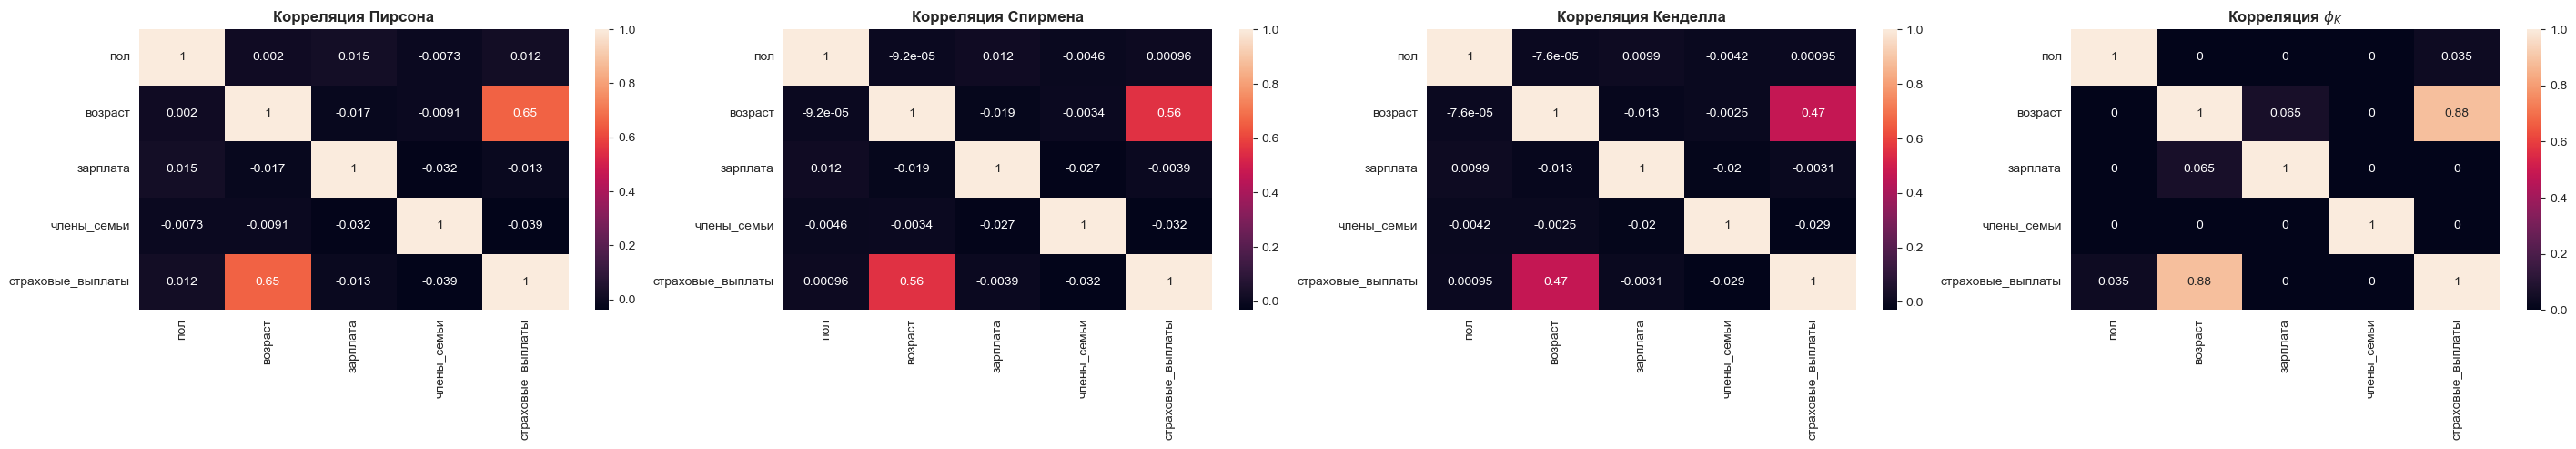

In [13]:
corr_psk(data)

На всех тепловых картах мультиколлинеарность признаков отсутствует<br>
С целевым признаком корреляция у признака `возраст` в диапазоне слабая-средняя<br>
У категориального признака `пол` очень слабая корреляция с целевым признаком<br>

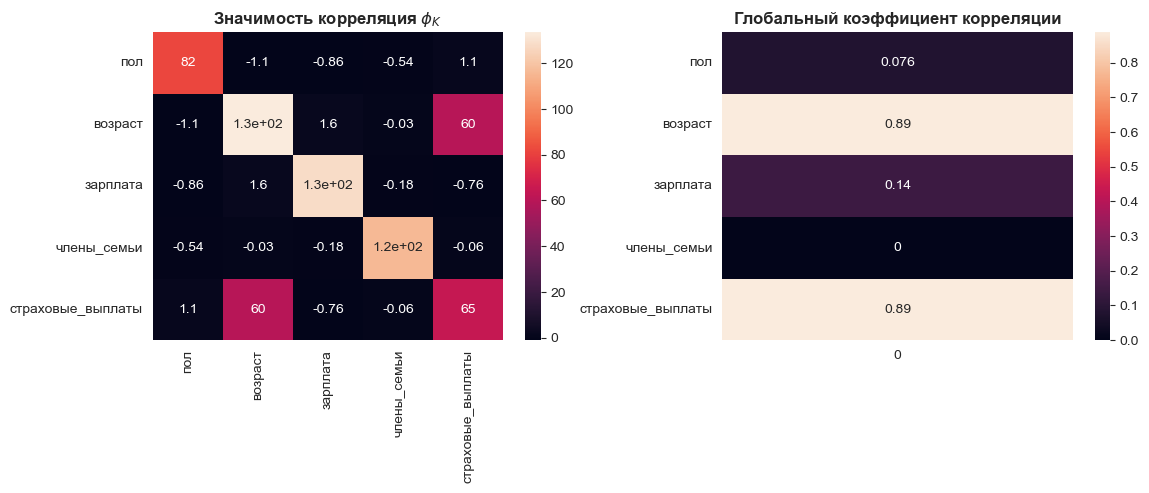

In [17]:
fig, (ax, ax1 ) = plt.subplots(1, 2, figsize=(13, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
significance_overview = data.significance_matrix(interval_cols=data.columns)
sns.heatmap(data = significance_overview.round(2), annot=True, ax=ax).set_title('Значимость корреляция $\phi_K$', weight='bold', size='large');
global_labels = data.global_phik(interval_cols=data.columns)
sns.heatmap(data=global_labels[0], yticklabels=global_labels[1], annot=True, ax=ax1).set_title('Глобальный коэффициент корреляции', weight='bold', size='large');

Значимость корреляции относительно целевого признака подтверждает признак `возраст`<br>
Категориальный признак имеет ничтожную значимость, а признак `члены семьи` почти нулевую <br>
У признака `члены семьи` нулевой глобальный коэффициент корреляции<br>

In [18]:
# посмотрим выбросы
def mustache_box(data, name):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    sns.boxplot(data=data, orient='h').set_title(name, weight='bold', size='large');
    plt.show()

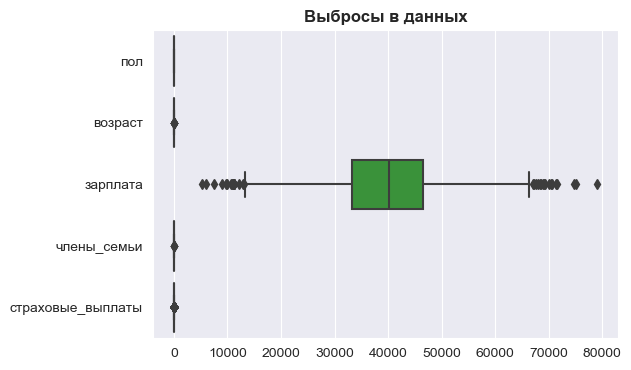

In [19]:
mustache_box(data=data, name='Выбросы в данных')

In [20]:
# функция размаха ящика с усами
def cut_crap(data, features):
    for features in features:
        q1 = np.percentile(data[features], 25)
        q3 = np.percentile(data[features], 75)
        min_ = q1-(1.5*(q3-q1))
        max_ = q3+(1.5*(q3-q1))
        data = data.loc[(data[features] > min_) & (data[features] < max_)]
    return data

In [21]:
# отфильтруем признаки от выбрасов по ящику с усами
list_features = ['пол', 'возраст', 'зарплата', 'члены_семьи']
data = cut_crap(data=data, features=list_features)

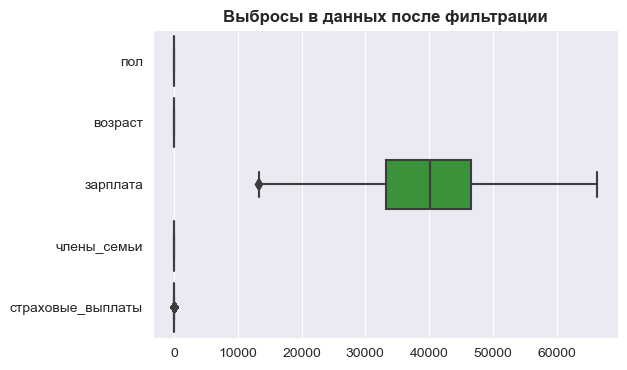

In [22]:
mustache_box(data=data, name='Выбросы в данных после фильтрации')

Отфильтровали данные от выбрасов

In [23]:
features = data.drop(columns='страховые_выплаты', axis=1)
target = data['страховые_выплаты']

In [33]:
model = LinearRegression()
model.fit(features, target);

In [32]:
angle_coefficients = pd.DataFrame([model.coef_.round(5)], columns=list_features)
angle_coefficients['intercept'] = model.intercept_
angle_coefficients

,пол,возраст,зарплата,члены_семьи,intercept
0,0.00547,0.03358,0.0,-0.01402,-0.887187


Коэффициент признака `зарплата` определяется в нуле поэтому его полезность ничему не равна и мы могли бы его удалить<br>
Нашей задачей является преобразовать данные таким образом, чтобы качество модели до преобразования и после сохранилось<br>
По этому оставим все признаки как есть <br>

## Умножение матриц

В этом задании вы можете записывать формулы в *Jupyter Notebook.*

Чтобы записать формулу внутри текста, окружите её символами доллара \\$; если снаружи —  двойными символами \\$\\$. Эти формулы записываются на языке вёрстки *LaTeX.* 

Для примера мы записали формулы линейной регрессии. Можете их скопировать и отредактировать, чтобы решить задачу.

Работать в *LaTeX* необязательно.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** ...

**Обоснование:** ...

## Алгоритм преобразования

**Алгоритм**

...

**Обоснование**

...

## Проверка алгоритма

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные загружены
- [ ]  Выполнен шаг 2: получен ответ на вопрос об умножении матриц
    - [ ]  Указан правильный вариант ответа
    - [ ]  Вариант обоснован
- [ ]  Выполнен шаг 3: предложен алгоритм преобразования
    - [ ]  Алгоритм описан
    - [ ]  Алгоритм обоснован
- [ ]  Выполнен шаг 4: алгоритм проверен
    - [ ]  Алгоритм реализован
    - [ ]  Проведено сравнение качества моделей до и после преобразования